In [1]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
def load_images_from_folder(folder_path, target_size=(120, 120)):
    """
    Memuat gambar dari folder, mengubahnya menjadi grayscale, dan mengembalikan gambar serta label.
    
    Parameters:
        folder_path (str): Path ke folder dataset.
        target_size (tuple): Ukuran gambar yang diinginkan setelah resize.
    
    Returns:
        images (np.array): Array gambar.
        labels (np.array): Array label.
    """
    images = []
    labels = []

    for person_name in os.listdir(folder_path):
        person_path = os.path.join(folder_path, person_name)
        if os.path.isdir(person_path):
            for img_name in os.listdir(person_path):
                img_path = os.path.join(person_path, img_name)
                try:
                    if img_path.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
                        img = Image.open(img_path).convert('L').resize(target_size)  # Grayscale dan resize
                        img = np.array(img) / 255.0  # Normalisasi pixel ke [0, 1]
                        images.append(img)
                        labels.append(person_name)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")
    
    images = np.expand_dims(np.array(images), axis=-1)  # Tambahkan channel untuk grayscale
    return images, np.array(labels)

In [6]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_and_balance_dataset(inputs1, inputs2, labels, num_augmentations=5):
    """
    Melakukan augmentasi pada seluruh dataset untuk Siamese Network.
    
    Parameters:
        inputs1 (array): Array input pertama (misal, citra wajah 1).
        inputs2 (array): Array input kedua (misal, citra wajah 2).
        labels (array): Label dataset.
        num_augmentations (int): Jumlah augmentasi yang diinginkan per gambar.

    Returns:
        inputs1_augmented, inputs2_augmented, labels_augmented: Dataset dengan augmentasi.
    """
    augmented_images1 = []
    augmented_images2 = []
    augmented_labels = []

    for i in range(len(inputs1)):
        img1 = inputs1[i]
        img2 = inputs2[i]
        label = labels[i]
        
        # Tambahkan gambar asli ke dataset augmentasi
        augmented_images1.append(img1)
        augmented_images2.append(img2)
        augmented_labels.append(label)
        
        # Tambahkan gambar hasil augmentasi
        for _ in range(num_augmentations):
            aug_img1 = datagen.random_transform(img1)
            aug_img2 = datagen.random_transform(img2)
            augmented_images1.append(aug_img1)
            augmented_images2.append(aug_img2)
            augmented_labels.append(label)
    
    # Konversi ke array NumPy
    inputs1_augmented = np.array(augmented_images1)
    inputs2_augmented = np.array(augmented_images2)
    labels_augmented = np.array(augmented_labels)
    
    return inputs1_augmented, inputs2_augmented, labels_augmented

In [7]:
def create_pairs(images, labels):
    """
    Membuat pasangan gambar positif (label=1) dan negatif (label=0) untuk Siamese Network.

    Parameters:
        images (array): Array gambar.
        labels (array): Array label gambar.

    Returns:
        pairs: Pasangan gambar (inputs1, inputs2).
        pair_labels: Label pasangan (1 untuk positif, 0 untuk negatif).
    """
    pairs = []
    pair_labels = []
    identity_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}
    
    for label, indices in identity_indices.items():
        n_samples = len(indices)
        
        # Membuat pasangan positif
        for i in range(n_samples - 1):
            z1, z2 = indices[i], indices[i + 1]
            pairs.append([images[z1], images[z2]])
            pair_labels.append(1)
        
        # Membuat pasangan negatif
        other_labels = [l for l in identity_indices if l != label]
        for i in range(n_samples):
            z1 = indices[i]
            other_label = random.choice(other_labels)
            z2 = random.choice(identity_indices[other_label])
            pairs.append([images[z1], images[z2]])
            pair_labels.append(0)
    
    pairs = np.array(pairs, dtype=object)  # Pisahkan input pasangan menjadi dua array
    inputs1 = np.stack(pairs[:, 0])
    inputs2 = np.stack(pairs[:, 1])
    
    return (inputs1, inputs2), np.array(pair_labels).astype('float32')

In [8]:
if __name__ == "__main__":
    import random

    # Path folder dataset
    folder_path = "dataset_siamese"  # Ganti dengan path dataset Anda
    
    # Load gambar dan label
    images, labels = load_images_from_folder(folder_path)
    print(f"Original dataset size: {len(labels)}")
    
    # Augmentasi seluruh dataset
    inputs1_aug, inputs2_aug, labels_aug = augment_and_balance_dataset(images, images, labels, num_augmentations=5)
    print(f"Augmented dataset size: {len(labels_aug)}")
    
    # Buat pasangan gambar untuk Siamese Network
    pairs, pair_labels = create_pairs(inputs1_aug, labels_aug)
    print(f"Number of pairs created: {len(pair_labels)}")

Original dataset size: 69
Augmented dataset size: 414
Number of pairs created: 821


In [9]:
import matplotlib.pyplot as plt

def show_images(images, labels=None, title="Images", num_images=5, cmap='gray'):
    """
    Menampilkan sejumlah gambar beserta labelnya (jika ada).

    Parameters:
        images (array): Array gambar.
        labels (array, optional): Array label gambar. Default None.
        title (str): Judul plot. Default "Images".
        num_images (int): Jumlah gambar yang ditampilkan. Default 5.
        cmap (str): Colormap untuk menampilkan gambar. Default 'gray'.
    """
    num_images = min(len(images), num_images)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        
        # Jika gambar memiliki 1 channel, hilangkan dimensi channel-nya
        img = images[i].squeeze() if images[i].ndim == 3 and images[i].shape[-1] == 1 else images[i]
        
        plt.imshow(img, cmap=cmap)
        
        if labels is not None and i < len(labels):
            plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [10]:
def show_image_pairs_separated(pairs, pair_labels, label_to_show, title="Image Pairs", num_pairs=5, cmap='gray'):
    """
    Menampilkan pasangan gambar berdasarkan label tertentu (positif atau negatif).
    
    Parameters:
        pairs (list): Daftar pasangan gambar [images1, images2].
        pair_labels (array): Array label pasangan (0 atau 1).
        label_to_show (int): Label pasangan yang ingin ditampilkan (0 atau 1).
        title (str): Judul plot. Default "Image Pairs".
        num_pairs (int): Jumlah pasangan gambar yang ditampilkan. Default 5.
        cmap (str): Colormap untuk menampilkan gambar. Default 'gray'.
    """
    # Filter pasangan berdasarkan label
    filtered_indices = np.where(pair_labels == label_to_show)[0]
    
    if len(filtered_indices) == 0:
        print(f"No pairs found with label {label_to_show}.")
        return
    
    filtered_pairs = [pairs[0][filtered_indices], pairs[1][filtered_indices]]
    
    num_pairs = min(len(filtered_indices), num_pairs)
    plt.figure(figsize=(10, num_pairs * 2))
    
    for i in range(num_pairs):
        # Gambar pertama pasangan
        plt.subplot(num_pairs, 2, 2 * i + 1)
        img1 = filtered_pairs[0][i]
        if img1.dtype != 'float32':  # Konversi tipe data jika diperlukan
            img1 = np.array(img1, dtype='float32')  
        plt.imshow(img1, cmap=cmap)
        plt.title(f"Image 1 (Pair {i+1})")
        plt.axis('off')
        
        # Gambar kedua pasangan
        plt.subplot(num_pairs, 2, 2 * i + 2)
        img2 = filtered_pairs[1][i]
        if img2.dtype != 'float32':  # Konversi tipe data jika diperlukan
            img2 = np.array(img2, dtype='float32')  
        plt.imshow(img2, cmap=cmap)
        plt.title(f"Image 2 (Label: {label_to_show})")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Original dataset size: 69


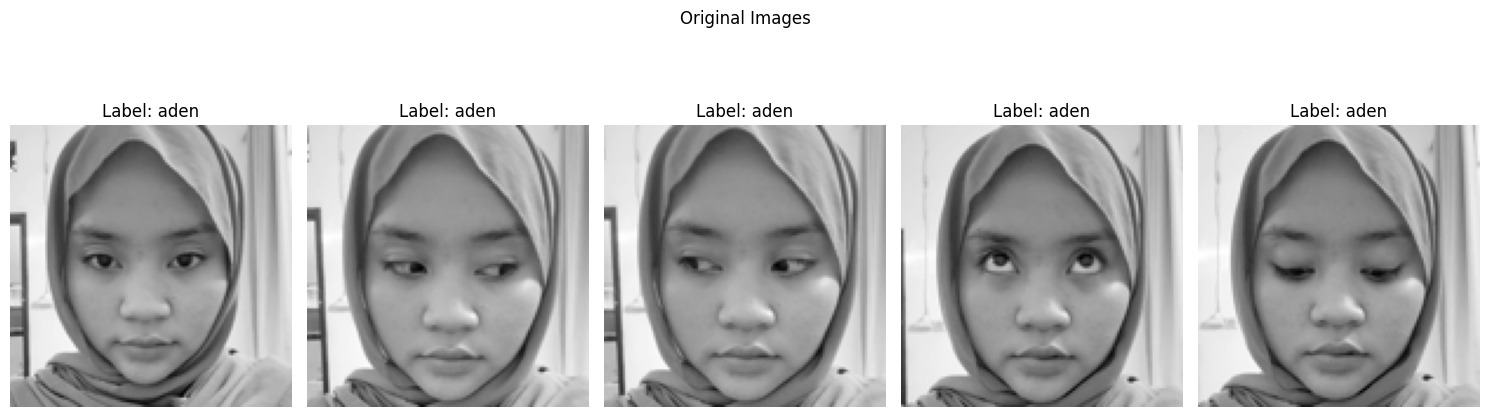

Augmented dataset size: 276
Number of pairs created: 545
Menampilkan pasangan positif:


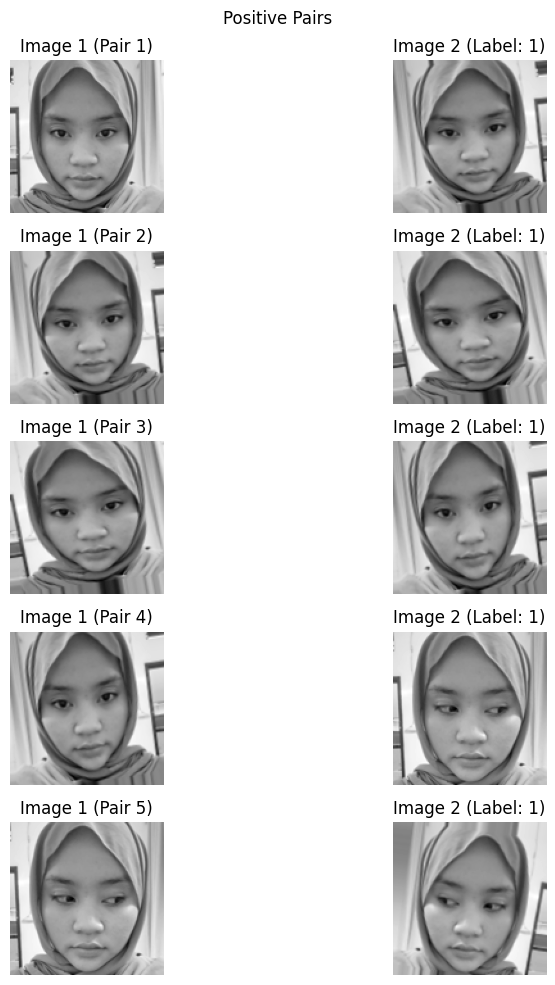

Menampilkan pasangan negatif:


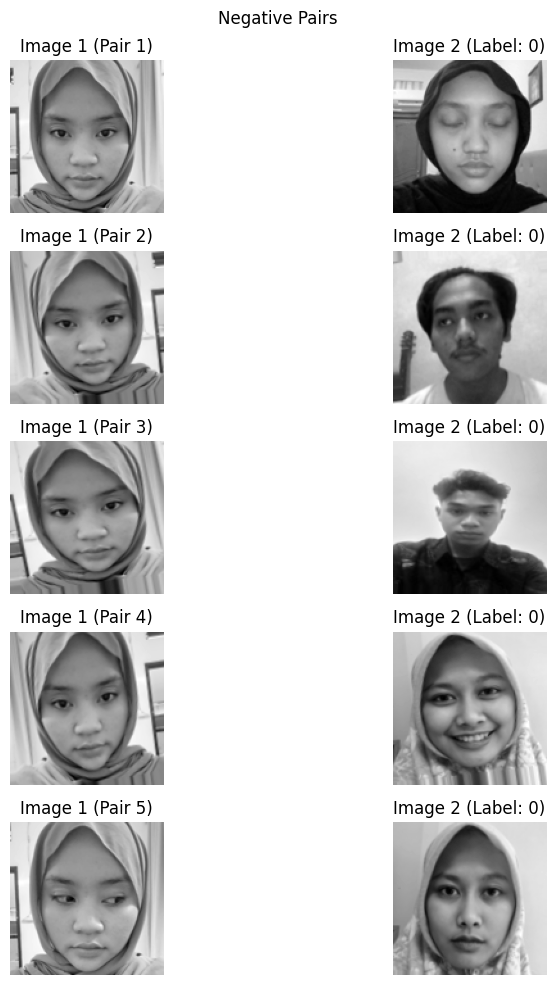

In [11]:
# Load gambar dan label
images, labels = load_images_from_folder(folder_path)
print(f"Original dataset size: {len(labels)}")

# Tampilkan beberapa gambar asli
show_images(images, labels, title="Original Images", num_images=5)

# Augmentasi seluruh dataset
inputs1_aug, inputs2_aug, labels_aug = augment_and_balance_dataset(images, images, labels, num_augmentations=3)
print(f"Augmented dataset size: {len(labels_aug)}")

# Buat pasangan gambar untuk Siamese Network
pairs, pair_labels = create_pairs(inputs1_aug, labels_aug)
print(f"Number of pairs created: {len(pair_labels)}")

# Tampilkan pasangan positif
print("Menampilkan pasangan positif:")
show_image_pairs_separated(pairs, pair_labels, label_to_show=1, title="Positive Pairs", num_pairs=5)

# Tampilkan pasangan negatif
print("Menampilkan pasangan negatif:")
show_image_pairs_separated(pairs, pair_labels, label_to_show=0, title="Negative Pairs", num_pairs=5)


In [12]:
from sklearn.model_selection import train_test_split

# Gabungkan pasangan gambar menjadi satu array
pairs_combined = np.stack(pairs, axis=1)  # Shape: (num_pairs, 2, height, width, channels)

# Split data menjadi training dan testing
train_pairs_combined, test_pairs_combined, train_labels, test_labels = train_test_split(
    pairs_combined, pair_labels, test_size=0.3, random_state=42
)

# Pisahkan kembali pasangan gambar menjadi inputs1 dan inputs2
train_pairs = [train_pairs_combined[:, 0], train_pairs_combined[:, 1]]
test_pairs = [test_pairs_combined[:, 0], test_pairs_combined[:, 1]]

print(f"Train pairs: {len(train_pairs[0])}, Test pairs: {len(test_pairs[0])}")


Train pairs: 381, Test pairs: 164


In [13]:
# Ubah train_pairs dan test_pairs menjadi array NumPy
train_pairs = np.array(train_pairs)
test_pairs = np.array(test_pairs)

# Ubah tipe data ke float32
train_pairs = train_pairs.astype('float32')
test_pairs = test_pairs.astype('float32')

print(f"Train pairs shape: {train_pairs.shape}, Test pairs shape: {test_pairs.shape}")

Train pairs shape: (2, 381, 120, 120, 1), Test pairs shape: (2, 164, 120, 120, 1)


In [30]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

@register_keras_serializable()
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [32]:
def initialize_base_network():
    input = Input(shape=(120,120,1), name="base_input")
    # first cnn layer
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(2e-3))(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)

    #second cnn layer
    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(2e-3))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    #third cnn layer
    x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(2e-3))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    x = Flatten(name="flatten_input")(x)
    x = Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(2e-3), name="first_base_dense")(x)
    x = Dropout(0.1)(x)

    return Model(inputs=input, outputs=x)

In [33]:
# create the left input and point to the base network
base_network = initialize_base_network()
input_a = Input(shape=(120,120,1), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(120,120,1), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

In [34]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 512)       │ 11,168,768 │ left_input[0][0], │
│ (Functional)        │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │          0 │ functional[0][0], │
│ (Lambda)            │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,168,768 (42.61 MB)

 Trainable params: 11,168,768 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
@register_keras_serializable()
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [36]:
# Mengubah dimensi data pasangan
train_pairs = np.transpose(train_pairs, (1, 0, 2, 3, 4))  # Mengubah bentuk menjadi (166, 2, 120, 120, 3)
test_pairs = np.transpose(test_pairs, (1, 0, 2, 3, 4))  # Mengubah bentuk menjadi (166, 2, 120, 120, 3)

print(f"Shape of train_pairs after transpose: {train_pairs.shape}")  # (166, 2, 120, 120, 3)
print(f"Shape of train_labels: {train_labels.shape}")  # (166,)

print(f"Shape of test_pairs after transpose: {test_pairs.shape}")  # (166, 2, 120, 120, 3)
print(f"Shape of test_labels: {test_labels.shape}")  # (166,)


Shape of train_pairs after transpose: (381, 2, 120, 120, 1)
Shape of train_labels: (381,)
Shape of test_pairs after transpose: (164, 2, 120, 120, 1)
Shape of test_labels: (164,)


In [37]:
from tensorflow.keras.callbacks import Callback

# Define a Callback class that stops training once loss reaches a threshold
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Set a threshold for loss, for example: 0.1
        if logs['loss'] < 0.1 and logs['val_loss']<0.1:
            self.model.stop_training = True
            print("\nReached desired loss value so cancelling training!")

# Instantiate the early stopping callback
early_stopping_callback = EarlyStoppingCallback()

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Tentukan ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_modelaugmentasi1.keras',
                                                monitor='val_loss', 
                                                save_best_only=True, 
                                                save_weights_only=False, 
                                                verbose=1)

# Kompilasi model dan latih
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=optimizer)

history = model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], train_labels,
    epochs=100, 
    batch_size=32,
    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels),
    callbacks=[checkpoint, early_stopping_callback]
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 7.2966
Epoch 1: val_loss improved from inf to 2.59703, saving model to best_modelaugmentasi1.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 735ms/step - loss: 7.0600 - val_loss: 2.5970
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 2.4050
Epoch 2: val_loss improved from 2.59703 to 2.11950, saving model to best_modelaugmentasi1.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 619ms/step - loss: 2.3987 - val_loss: 2.1195
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 2.0723
Epoch 3: val_loss improved from 2.11950 to 1.71115, saving model to best_modelaugmentasi1.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 626ms/step - loss: 2.0640 - val_loss: 1.7112
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 1.6405
Epoch 4: val_loss improved from 1.71115 to 1.33687, saving model to best_modelaugmentasi1.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 705ms/step - loss: 1.6344 - val_loss: 1.3369
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms

In [38]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [39]:
loss = model.evaluate(x=[test_pairs[:,0],test_pairs[:,1]], y=test_labels)

y_pred_train = model.predict([train_pairs[:,0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_labels, y_pred_train)

y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_labels, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0999 
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Loss = 0.09669099003076553, Train Accuracy = 0.9896640826873385 Test Accuracy = 0.9879518072289156


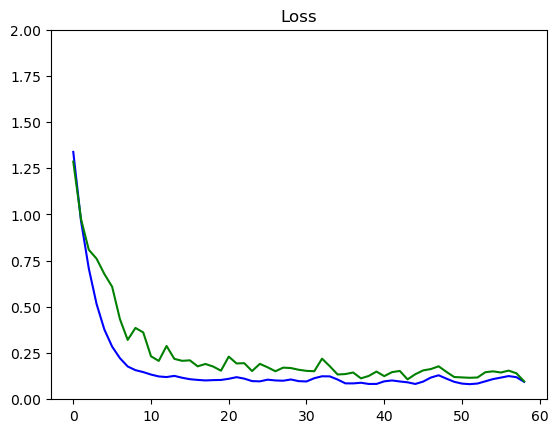

In [40]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=2)

In [43]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 120,120,1])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [120, 120*n,1])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([120*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 120,120,1])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [120, 120*n,1])
    plt.imshow(right)



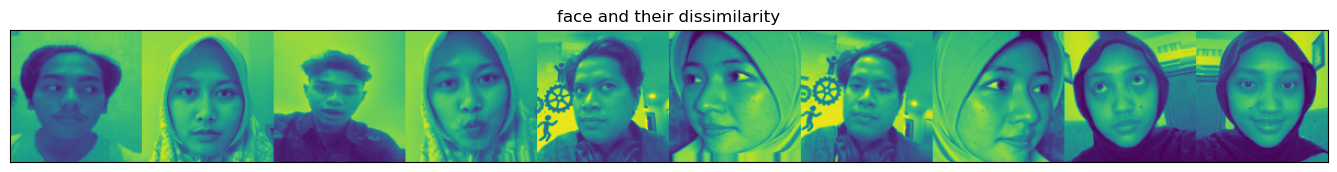

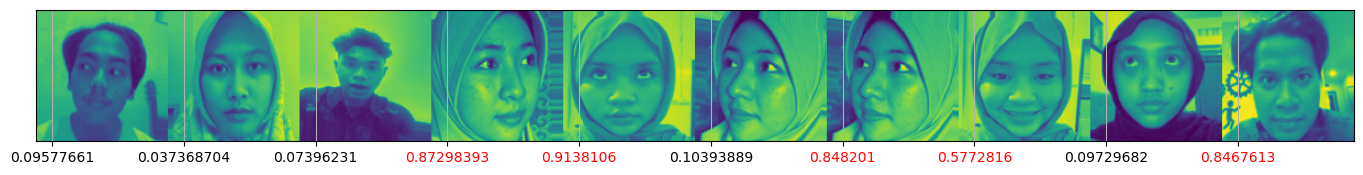

In [44]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(train_pairs[:, 0][indexes], train_pairs[:, 1][indexes], y_pred_train[indexes], train_labels[indexes], "face and their dissimilarity",10)

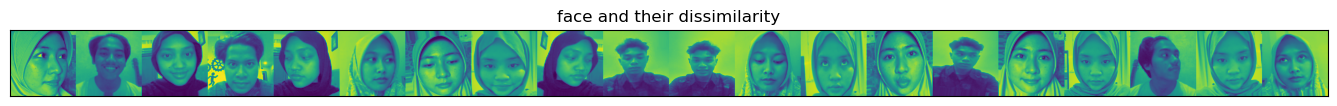

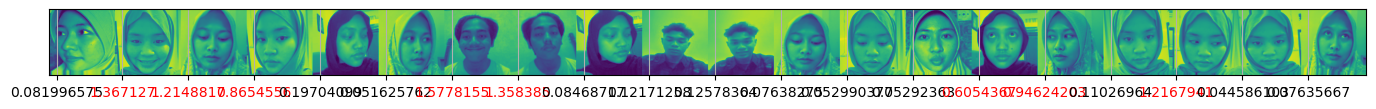

In [47]:
y_pred_test = np.squeeze(y_pred_test)
indexes = np.random.choice(len(y_pred_test), size=20)
display_images(test_pairs[:, 0][indexes], test_pairs[:, 1][indexes], y_pred_test[indexes], test_labels[indexes], "face and their dissimilarity",20)

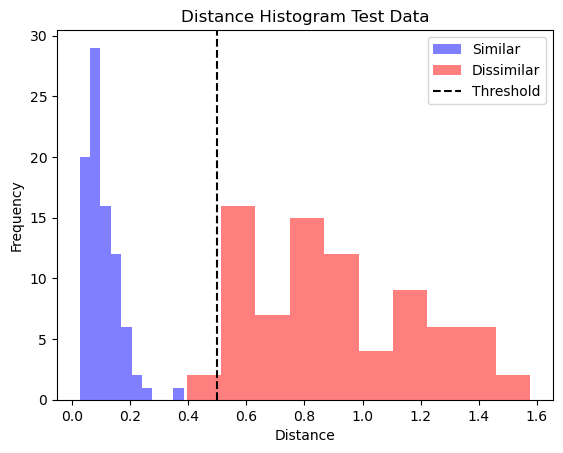

In [48]:
# Contoh jarak dari pasangan mirip dan tidak mirip
distances_similar = y_pred_test[test_labels == 1]  # Pasangan mirip
distances_dissimilar = y_pred_test[test_labels == 0] # Pasangan tidak mirip

# Visualisasi histogram
plt.hist(distances_similar, bins=10, alpha=0.5, label="Similar", color="blue")
plt.hist(distances_dissimilar, bins=10, alpha=0.5, label="Dissimilar", color="red")
plt.axvline(x=0.5, color='black', linestyle='--', label="Threshold")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distance Histogram Test Data")
plt.legend()
plt.show()

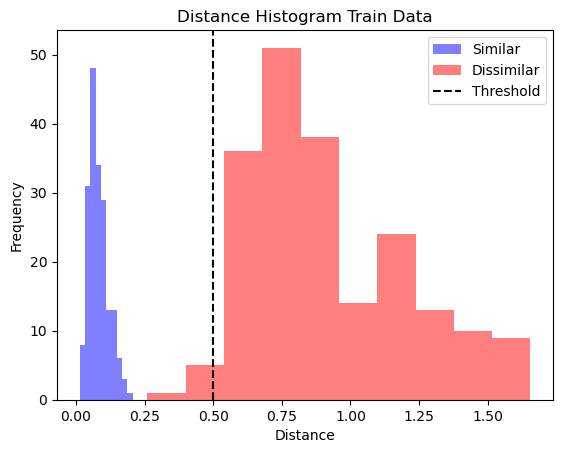

In [49]:
# Contoh jarak dari pasangan mirip dan tidak mirip
distances_similar = y_pred_train[train_labels == 1]  # Pasangan mirip
distances_dissimilar = y_pred_train[train_labels == 0] # Pasangan tidak mirip

# Visualisasi histogram
plt.hist(distances_similar, bins=10, alpha=0.5, label="Similar", color="blue")
plt.hist(distances_dissimilar, bins=10, alpha=0.5, label="Dissimilar", color="red")
plt.axvline(x=0.5, color='black', linestyle='--', label="Threshold")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distance Histogram Train Data")
plt.legend()
plt.show()

In [56]:
def preprocess_images(image_path_1, image_path_2, target_size):
    """
    Fungsi untuk memuat dan memproses dua gambar.
    """
    # Proses gambar pertama
    img1 = load_img(image_path_1, target_size=target_size, color_mode="grayscale")
    img_array_1 = img_to_array(img1) / 255.0
    img_array_1 = np.expand_dims(img_array_1, axis=0)

    # Proses gambar kedua
    img2 = load_img(image_path_2, target_size=target_size, color_mode="grayscale")
    img_array_2 = img_to_array(img2) / 255.0
    img_array_2 = np.expand_dims(img_array_2, axis=0)

    return img_array_1, img_array_2

In [57]:

def predict_siamese(model, image_path_1, image_path_2, target_size=(120, 120)):
    """
    Fungsi untuk memproses dua gambar dan menghasilkan prediksi dari model Siamese.
    """
    # Preproses kedua gambar
    img_array_1, img_array_2 = preprocess_images(image_path_1, image_path_2, target_size)

    # Lakukan prediksi dengan dua input
    prediction = model.predict([img_array_1, img_array_2])

    # Cetak hasil prediksi
    print("Hasil prediksi (kemiripan):", prediction)

    # Tampilkan kedua gambar
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    img1 = load_img(image_path_1, target_size=target_size, color_mode="grayscale")
    plt.imshow(img_to_array(img1).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Gambar 1")

    plt.subplot(1, 2, 2)
    img2 = load_img(image_path_2, target_size=target_size, color_mode="grayscale")
    plt.imshow(img_to_array(img2).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Gambar 2")

    plt.suptitle(f"Prediction (similarity): {prediction[0][0]:.2f}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Hasil prediksi (kemiripan): [[0.37353373]]


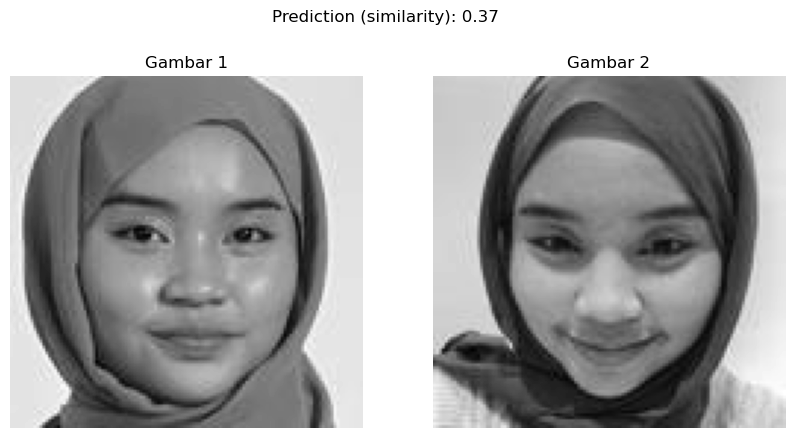

In [80]:
image_path_1 = "Foto ML/validation/aden/5.jpg"
image_path_2 = "Foto ML/validation/aden/2.jpg"

predict_siamese(model, image_path_1, image_path_2, target_size=(120, 120))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Hasil prediksi (kemiripan): [[0.49373066]]


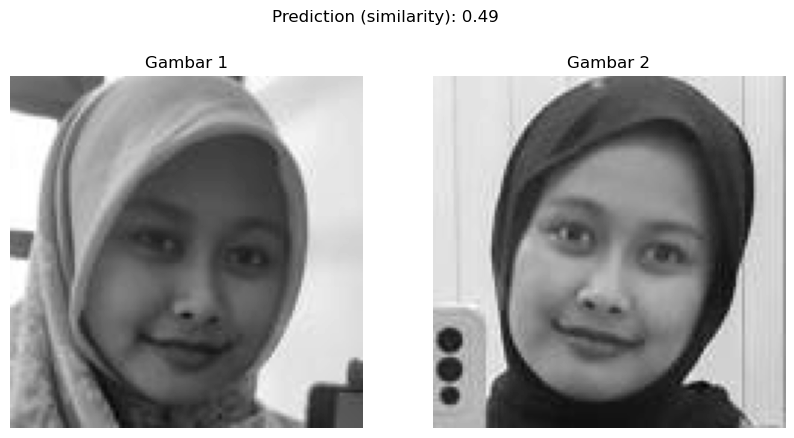

In [83]:
image_path_1 = "Foto ML/validation/affa/7.jpg"
image_path_2 = "Foto ML/validation/affa/8.jpg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Hasil prediksi (kemiripan): [[1.5210346]]


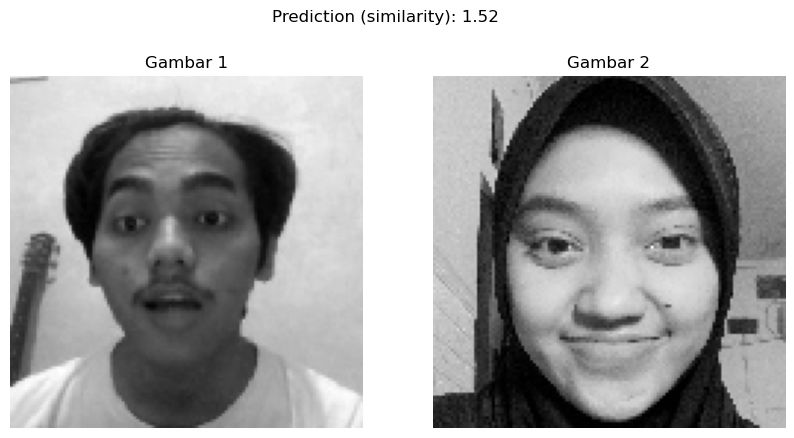

In [61]:
image_path_1 = "dataset_siamese/azki/1.jpg"
image_path_2 = "Foto ML/validation/ajeng/9.jpeg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Hasil prediksi (kemiripan): [[0.20665178]]


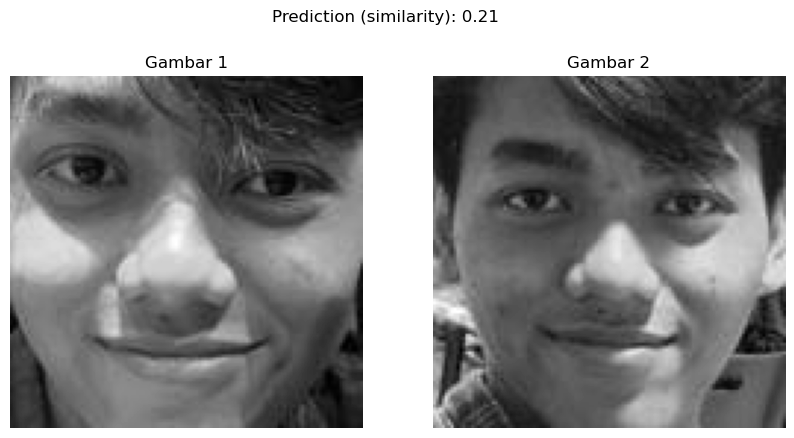

In [67]:
image_path_1 = "Foto ML/validation/azki/4.jpg"
image_path_2 = "Foto ML/validation/azki/7.jpg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Hasil prediksi (kemiripan): [[0.02472959]]


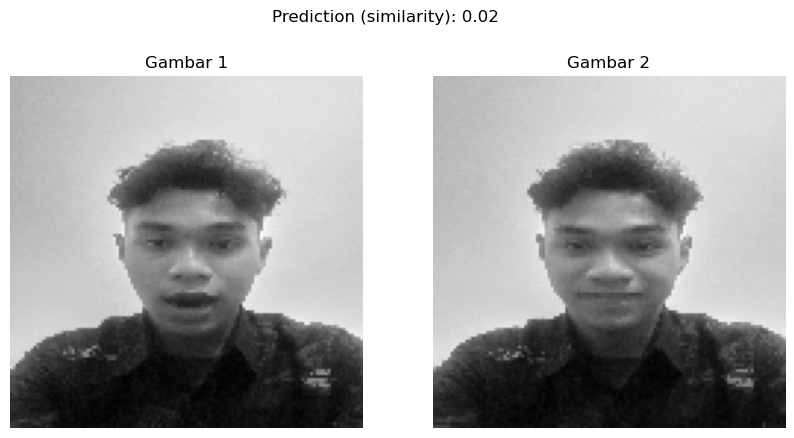

In [68]:
image_path_1 = "dataset_siamese/angga/1.jpg"
image_path_2 = "dataset_siamese/angga/7.jpg"
# image_path_2 = "Foto ML/validation/angga/2.jpg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Hasil prediksi (kemiripan): [[0.10184395]]


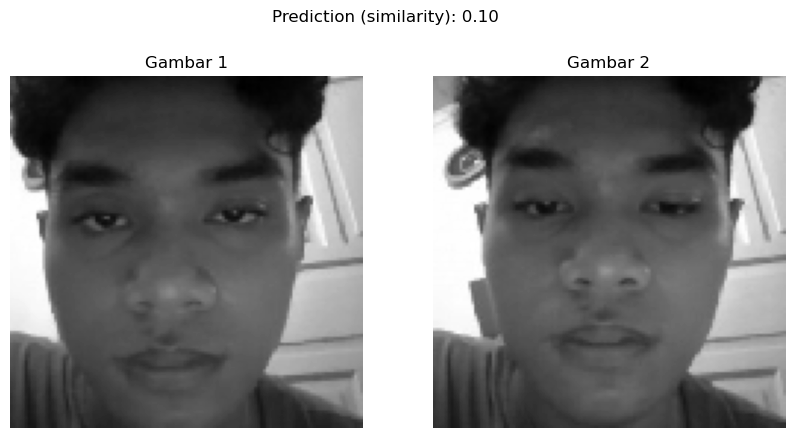

In [71]:
image_path_1 = "Foto ML/validation/angga/9.jpg"
image_path_2 = "Foto ML/validation/angga/4.jpg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Hasil prediksi (kemiripan): [[0.62938094]]


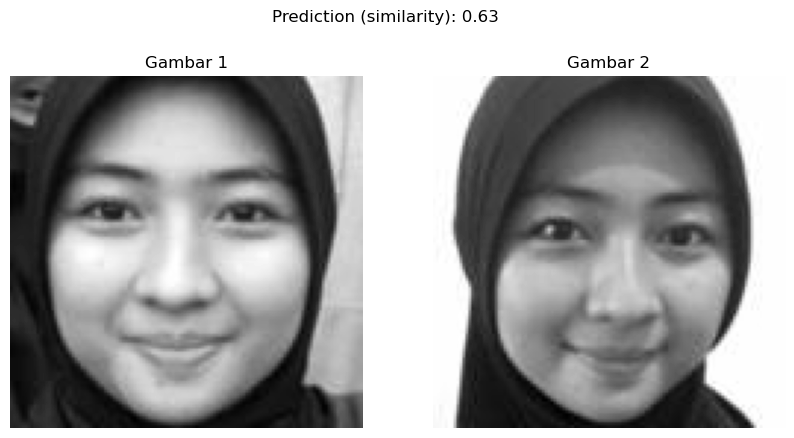

In [77]:
image_path_1 = "Foto ML/validation/melin/1.jpg"
image_path_2 = "Foto ML/validation/melin/8.jpg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Hasil prediksi (kemiripan): [[0.6029475]]


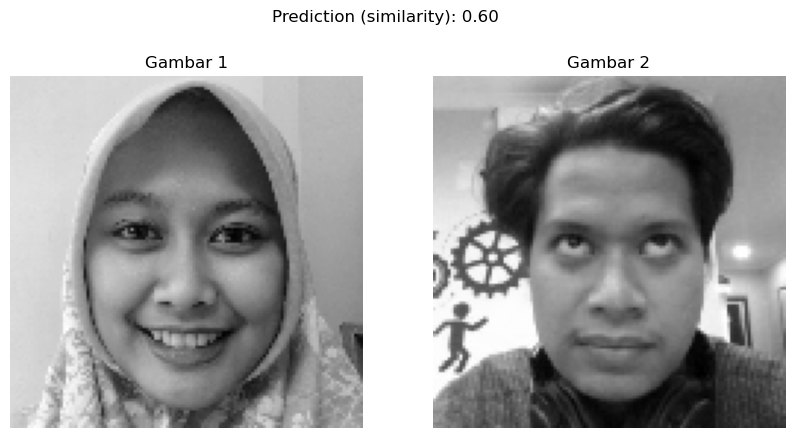

In [85]:
image_path_1 = "dataset_siamese/affa/5.jpg"
image_path_2 = "dataset_siamese/dyo/4.jpg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Hasil prediksi (kemiripan): [[0.33797142]]


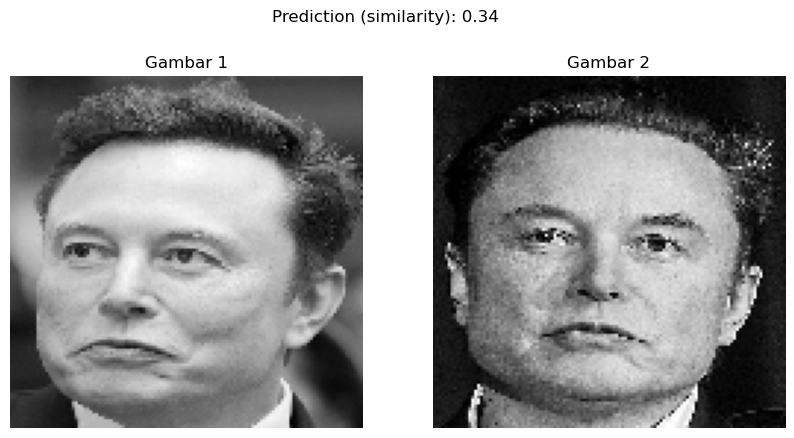

In [84]:
image_path_1 = "elon-1.jpg"
image_path_2 = "elon-2.jpg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Hasil prediksi (kemiripan): [[0.49586347]]


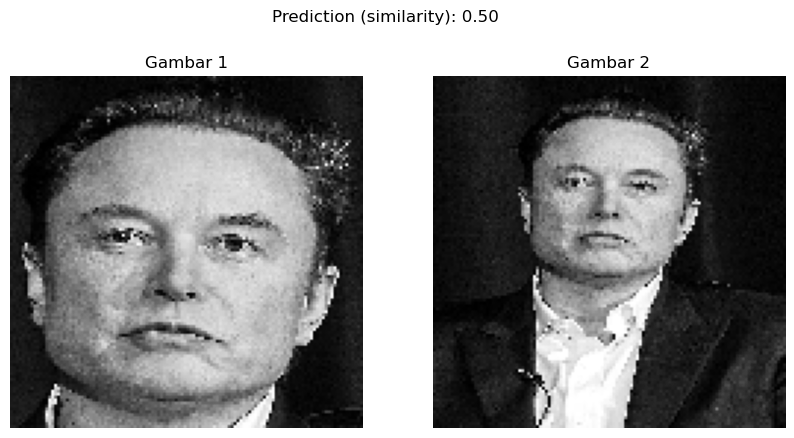

In [86]:
image_path_1 = "elon-2.jpg"
image_path_2 = "elon-3.jpg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Hasil prediksi (kemiripan): [[0.44708014]]


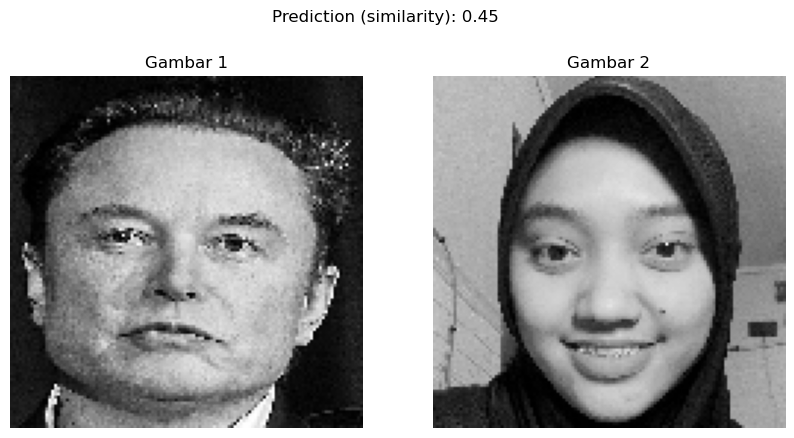

In [87]:
image_path_1 = "elon-2.jpg"
image_path_2 = "Foto ML/validation/ajeng/2.jpeg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Hasil prediksi (kemiripan): [[0.3123129]]


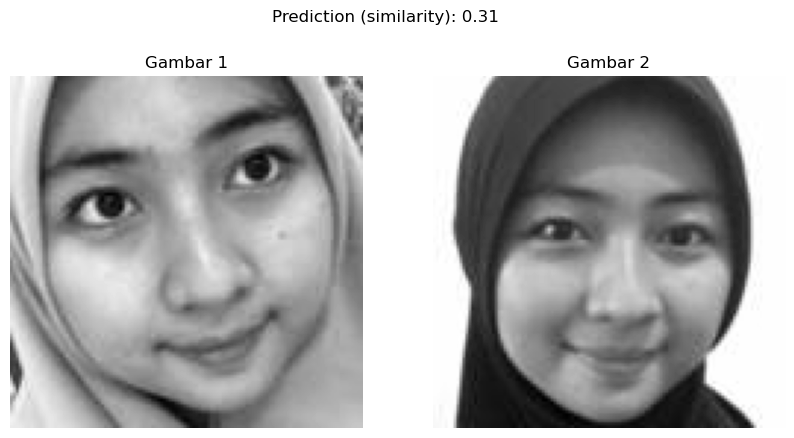

In [93]:
image_path_1 = "Foto ML/validation/melin/6.jpg"
image_path_2 = "Foto ML/validation/melin/8.jpg"

predict_siamese(model, image_path_1, image_path_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Hasil prediksi (kemiripan): [[0.73166853]]


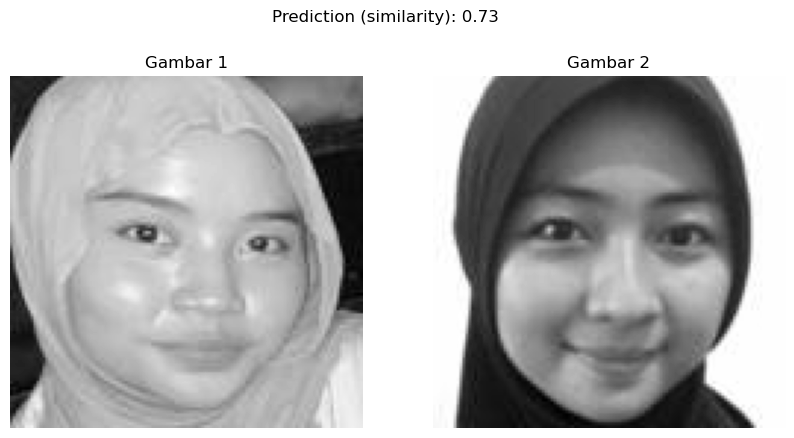

In [103]:
image_path_1 = "Foto ML/validation/aden/9.jpg"
image_path_2 = "Foto ML/validation/melin/8.jpg"

predict_siamese(model, image_path_1, image_path_2)

In [ ]:
# model.save('siamese_model_augmentasi.h5')  # Menyimpan model dalam format H5